# Week7_Jingyi Fu

# 1.) Import an asset price from Yahoo Finance

In [18]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("META", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]


[*********************100%***********************]  1 of 1 completed


In [20]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...
2022-02-14,219.309998,221.000000,214.779999,217.699997,217.699997,38184000
2022-02-15,220.470001,221.149994,215.059998,221.000000,221.000000,42685500
2022-02-16,212.410004,217.460007,212.360001,216.539993,216.539993,45817500


In [21]:
train_data

array([[-0.10986139],
       [-0.08903905],
       [ 0.03225806],
       ...,
       [-0.06400131],
       [ 0.05126845],
       [-0.04461528]])

# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [31]:
x_train = []
y_train = []
train1 = []

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################

# input of lags
input_size = 4
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train_variable = train_data[i, 0]
    if y_train_variable > 0:
      y_train.append(1)
    else:
      y_train.append(0)



x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [32]:
x_train.shape

(1960, 4, 1)

In [33]:
x_train

array([[[-0.10986139],
        [-0.08903905],
        [ 0.03225806],
        [ 0.03218746]],

       [[-0.08903905],
        [ 0.03225806],
        [ 0.03218746],
        [-0.03390854]],

       [[ 0.03225806],
        [ 0.03218746],
        [-0.03390854],
        [-0.09620808]],

       ...,

       [[-0.05370598],
        [ 0.03157779],
        [-0.03436586],
        [-0.02203382]],

       [[ 0.03157779],
        [-0.03436586],
        [-0.02203382],
        [-0.06400131]],

       [[-0.03436586],
        [-0.02203382],
        [-0.06400131],
        [ 0.05126845]]])

In [34]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))

#not sure
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
#model.add(Dense(5)) put in dropout percentage
#Classification: pick your activation function
model.add(Dense(1))



model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1960/1960 [==============================] - 18s 7ms/step - loss: 0.2565
Epoch 2/3
1960/1960 [==============================] - 13s 7ms/step - loss: 0.2531
Epoch 3/3
1960/1960 [==============================] - 12s 6ms/step - loss: 0.2514


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [43]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = []

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    y_test_variable = test_data[i, 0]
    if y_test_variable > 0:
      y_test.append(1)
    else:
      y_test.append(0)

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [44]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [45]:
# Make predictions
predictions = model.predict(x_test)
predictions_binary = np.where(predictions > 0, 1, 0)


16/16 [==============================] - 0s 4ms/step


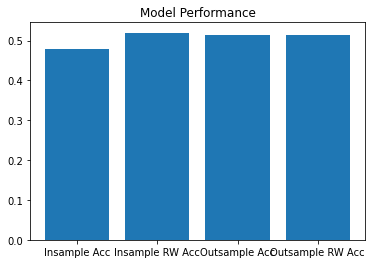

In [46]:
# Calculate in-sample accuracy and random walk assumption accuracy
insample_acc = accuracy_score(y_train[input_size:], np.where(y_train[input_size-1:-1] == 1, 1, 0))
insample_rw_acc = accuracy_score(y_train[input_size:], np.where(y_train[input_size-1:-1] == 0, 1, 0))

# Calculate out-of-sample accuracy and random walk assumption accuracy
outsample_acc = accuracy_score(y_test, predictions_binary)
outsample_rw_acc = accuracy_score(y_test[input_size:], np.where(y_test[input_size-1:-1] == 0, 1, 0))

# Plot the results
labels = ['Insample Acc', 'Insample RW Acc', 'Outsample Acc', 'Outsample RW Acc']
values = [insample_acc, insample_rw_acc, outsample_acc, outsample_rw_acc]
plt.bar(labels, values)
plt.title('Model Performance')
plt.show()

# DONT DO 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

51/51 [==============================] - 0s 2ms/step


ValueError: ignored

# 5) Write an observation/conclusion about the graphs from Q4 and Q3

The graph from Q3 shows the in sample accuracy is close to 0.5 and out of sample accuracy is 0.5, while random walk accuracy is a little bit larger than the model. We can conclude that the model can predict correctly with 50% probability and overall it is not much efficient.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [52]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM

# Define the Keras model
###Edit here to create your optimizer
def create_model():
    model = Sequential()
    #model.add(Dense(10, input_dim=60, activation='LSTM'))
    model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(25))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
param_grid = {'batch_size': [10, 20, 100],
        'epochs': [100],
        'input_size':[5,10,20]}


# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-52-7ddfd525d824>:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


ValueError: ignored